In [1]:
# Import required libraries
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd
import json


c:\Users\Ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to load a JSONL file into a DataFrame
def load_jsonl(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    return pd.DataFrame(data)


In [3]:
# Load the train dataset
train_df = load_jsonl("en_train.jsonl")  # Replace with the actual file path
print("Train Dataset Loaded:")
print(train_df.head())


Train Dataset Loaded:
                                     id source sub_source lang      model  \
0  f05034ca-d1da-445d-a6a2-5869ade0dfc3   m4gt     reddit   en  llama3-8b   
1  e7d7fe23-3709-4e14-aa2d-d76821dcbdf6   mage      squad   en      human   
2  1a68d42e-4202-4e36-bceb-02d693440a14   mage       yelp   en      human   
3  5de844ab-c197-4378-b144-c3a46e3f5b67   mage       xsum   en      human   
4  cdf050ad-7d90-4235-b7c6-46ca6cfc4382   m4gt  wikipedia   en      human   

   label                                               text  
0      1  Hitler's plans for the succession and power st...  
1      0  The Bush administration then turned its attent...  
2      0  Really really the best pedi ever! Pho was so a...  
3      0  The PS42m MV Loch Seaforth made its first pass...  
4      0  Malta participated in the Eurovision Song Cont...  


In [5]:
# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    train_df['text'].tolist(), train_df['label'].tolist(), test_size=0.2, random_state=42
)


In [6]:
# Convert the datasets into Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})

# Print the dataset to verify
print("Hugging Face Dataset Format:")
print(dataset)


Hugging Face Dataset Format:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 488613
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 122154
    })
})


In [7]:
from transformers import AutoTokenizer

# Load tokenizer for the pre-trained model (e.g., BERT or RoBERTa)
model_name = "bert-base-uncased"  # Replace with "roberta-base" for RoBERTa
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print("Tokenization Complete:")
print(tokenized_datasets)


Map: 100%|██████████| 122154/122154 [00:38<00:00, 3161.66 examples/s]

Tokenization Complete:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 488613
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 122154
    })
})


In [8]:
from transformers import AutoModelForSequenceClassification

# Load the pre-trained model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
print(f"Loaded pre-trained model: {model_name}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pre-trained model: bert-base-uncased


In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",        # Save checkpoint after every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Or "accuracy" based on your preference
    greater_is_better=True
)


print("Gradient accumulation applied for effective batch size of 512.")


Gradient accumulation applied for effective batch size of 512.


In [17]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

# Initialize the Trainer and adding EarlyStoppingCallback to the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Stop if no improvement for 5 eval steps
)

# Train the model
trainer.train()


C:\Users\Ragha\AppData\Local\Temp\ipykernel_11708\2447206826.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  1%|          | 301/45810 [30:04<75:47:04,  5.99s/it]
                                                      
 12%|█▏        | 2647/22905 [30:43<3:32:29,  1.59it/s]

{'loss': 0.0859, 'grad_norm': 2.345327138900757, 'learning_rate': 1.9781707050862258e-05, 'epoch': 0.03}


                                                      
 12%|█▏        | 2647/22905 [33:19<3:32:29,  1.59it/s]

{'loss': 0.0828, 'grad_norm': 4.691992282867432, 'learning_rate': 1.9563414101724515e-05, 'epoch': 0.07}


                                                      
 12%|█▏        | 2647/22905 [35:54<3:32:29,  1.59it/s]

{'loss': 0.0748, 'grad_norm': 0.8204674124717712, 'learning_rate': 1.934512115258677e-05, 'epoch': 0.1}


                                                      
 12%|█▏        | 2647/22905 [38:29<3:32:29,  1.59it/s]

{'loss': 0.0739, 'grad_norm': 3.273733139038086, 'learning_rate': 1.912682820344903e-05, 'epoch': 0.13}


                                                      
 12%|█▏        | 2647/22905 [41:04<3:32:29,  1.59it/s]

{'loss': 0.0618, 'grad_norm': 6.1648783683776855, 'learning_rate': 1.8908535254311288e-05, 'epoch': 0.16}


                                                      
 12%|█▏        | 2647/22905 [43:40<3:32:29,  1.59it/s]

{'loss': 0.0666, 'grad_norm': 5.522435665130615, 'learning_rate': 1.8690242305173544e-05, 'epoch': 0.2}


                                                      
 12%|█▏        | 2647/22905 [46:15<3:32:29,  1.59it/s]

{'loss': 0.0552, 'grad_norm': 6.130736351013184, 'learning_rate': 1.84719493560358e-05, 'epoch': 0.23}


                                                      
 12%|█▏        | 2647/22905 [48:50<3:32:29,  1.59it/s]

{'loss': 0.0589, 'grad_norm': 5.61468505859375, 'learning_rate': 1.825365640689806e-05, 'epoch': 0.26}


                                                      
 12%|█▏        | 2647/22905 [51:25<3:32:29,  1.59it/s]

{'loss': 0.0563, 'grad_norm': 2.7383873462677, 'learning_rate': 1.8035363457760314e-05, 'epoch': 0.29}


                                                      
 12%|█▏        | 2647/22905 [54:00<3:32:29,  1.59it/s]

{'loss': 0.053, 'grad_norm': 0.09367435425519943, 'learning_rate': 1.7817070508622574e-05, 'epoch': 0.33}


                                                      
 12%|█▏        | 2647/22905 [56:35<3:32:29,  1.59it/s]

{'loss': 0.0954, 'grad_norm': 5.145785331726074, 'learning_rate': 1.759877755948483e-05, 'epoch': 0.36}


                                                      
 12%|█▏        | 2647/22905 [59:10<3:32:29,  1.59it/s]

{'loss': 0.1301, 'grad_norm': 6.5646653175354, 'learning_rate': 1.7380484610347087e-05, 'epoch': 0.39}


                                                      
 12%|█▏        | 2647/22905 [1:01:45<3:32:29,  1.59it/s]

{'loss': 0.1268, 'grad_norm': 4.841528415679932, 'learning_rate': 1.7162191661209343e-05, 'epoch': 0.43}


                                                        
 12%|█▏        | 2647/22905 [1:04:20<3:32:29,  1.59it/s]

{'loss': 0.1222, 'grad_norm': 1.6721076965332031, 'learning_rate': 1.6943898712071603e-05, 'epoch': 0.46}


                                                        
 12%|█▏        | 2647/22905 [1:06:54<3:32:29,  1.59it/s]

{'loss': 0.1159, 'grad_norm': 1.4861323833465576, 'learning_rate': 1.672560576293386e-05, 'epoch': 0.49}


                                                        
 12%|█▏        | 2647/22905 [1:09:29<3:32:29,  1.59it/s]

{'loss': 0.118, 'grad_norm': 2.794738531112671, 'learning_rate': 1.6507312813796116e-05, 'epoch': 0.52}


                                                        
 12%|█▏        | 2647/22905 [1:12:04<3:32:29,  1.59it/s]

{'loss': 0.1119, 'grad_norm': 3.5313289165496826, 'learning_rate': 1.6289019864658373e-05, 'epoch': 0.56}


                                                        
 12%|█▏        | 2647/22905 [1:14:39<3:32:29,  1.59it/s]

{'loss': 0.1078, 'grad_norm': 3.8535633087158203, 'learning_rate': 1.607072691552063e-05, 'epoch': 0.59}


                                                        
 12%|█▏        | 2647/22905 [1:17:13<3:32:29,  1.59it/s]

{'loss': 0.1136, 'grad_norm': 3.1892120838165283, 'learning_rate': 1.5852433966382886e-05, 'epoch': 0.62}


                                                        
 12%|█▏        | 2647/22905 [1:19:48<3:32:29,  1.59it/s]

{'loss': 0.1092, 'grad_norm': 6.013555526733398, 'learning_rate': 1.5634141017245142e-05, 'epoch': 0.65}


                                                        
 12%|█▏        | 2647/22905 [1:22:23<3:32:29,  1.59it/s]

{'loss': 0.1099, 'grad_norm': 2.5470035076141357, 'learning_rate': 1.5415848068107402e-05, 'epoch': 0.69}


                                                        
 12%|█▏        | 2647/22905 [1:24:58<3:32:29,  1.59it/s]

{'loss': 0.1062, 'grad_norm': 5.099993705749512, 'learning_rate': 1.5197555118969659e-05, 'epoch': 0.72}


                                                        
 12%|█▏        | 2647/22905 [1:27:33<3:32:29,  1.59it/s]

{'loss': 0.1064, 'grad_norm': 2.7895610332489014, 'learning_rate': 1.4979262169831917e-05, 'epoch': 0.75}


                                                        
 12%|█▏        | 2647/22905 [1:30:07<3:32:29,  1.59it/s]

{'loss': 0.1027, 'grad_norm': 2.977416515350342, 'learning_rate': 1.4760969220694172e-05, 'epoch': 0.79}


                                                        
 12%|█▏        | 2647/22905 [1:32:43<3:32:29,  1.59it/s]

{'loss': 0.1015, 'grad_norm': 4.566120147705078, 'learning_rate': 1.454267627155643e-05, 'epoch': 0.82}


                                                        
 12%|█▏        | 2647/22905 [1:35:17<3:32:29,  1.59it/s]

{'loss': 0.1044, 'grad_norm': 4.559174537658691, 'learning_rate': 1.4324383322418687e-05, 'epoch': 0.85}


                                                        
 12%|█▏        | 2647/22905 [1:37:52<3:32:29,  1.59it/s]

{'loss': 0.0987, 'grad_norm': 4.927066802978516, 'learning_rate': 1.4106090373280945e-05, 'epoch': 0.88}


                                                        
 12%|█▏        | 2647/22905 [1:40:26<3:32:29,  1.59it/s]

{'loss': 0.097, 'grad_norm': 6.376720905303955, 'learning_rate': 1.3887797424143201e-05, 'epoch': 0.92}


                                                        
 12%|█▏        | 2647/22905 [1:43:01<3:32:29,  1.59it/s]

{'loss': 0.0977, 'grad_norm': 4.528350353240967, 'learning_rate': 1.366950447500546e-05, 'epoch': 0.95}


                                                        
 12%|█▏        | 2647/22905 [1:45:36<3:32:29,  1.59it/s]

{'loss': 0.0982, 'grad_norm': 5.629918098449707, 'learning_rate': 1.3451211525867716e-05, 'epoch': 0.98}


{'eval_loss': 0.20610415935516357, 'eval_accuracy': 0.9260278009725429, 'eval_precision': 0.900292214322051, 'eval_recall': 0.9920737351219576, 'eval_f1': 0.9439572298646688, 'eval_runtime': 451.683, 'eval_samples_per_second': 270.442, 'eval_steps_per_second': 33.807, 'epoch': 1.0}


                                                        
 12%|█▏        | 2647/22905 [1:55:44<3:32:29,  1.59it/s]

{'loss': 0.0811, 'grad_norm': 0.8181683421134949, 'learning_rate': 1.3232918576729971e-05, 'epoch': 1.02}


                                                        
 12%|█▏        | 2647/22905 [1:58:18<3:32:29,  1.59it/s]

{'loss': 0.0601, 'grad_norm': 0.48623931407928467, 'learning_rate': 1.301462562759223e-05, 'epoch': 1.05}


                                                        
 12%|█▏        | 2647/22905 [2:00:53<3:32:29,  1.59it/s]

{'loss': 0.0585, 'grad_norm': 2.31259822845459, 'learning_rate': 1.2796332678454486e-05, 'epoch': 1.08}


                                                        
 12%|█▏        | 2647/22905 [2:03:28<3:32:29,  1.59it/s]

{'loss': 0.0579, 'grad_norm': 4.803670406341553, 'learning_rate': 1.2578039729316744e-05, 'epoch': 1.11}


                                                        
 12%|█▏        | 2647/22905 [2:06:03<3:32:29,  1.59it/s]

{'loss': 0.056, 'grad_norm': 2.0337975025177, 'learning_rate': 1.2359746780179e-05, 'epoch': 1.15}


                                                        
 12%|█▏        | 2647/22905 [2:08:39<3:32:29,  1.59it/s]

{'loss': 0.0562, 'grad_norm': 4.5616021156311035, 'learning_rate': 1.2141453831041259e-05, 'epoch': 1.18}


                                                        
 12%|█▏        | 2647/22905 [2:11:15<3:32:29,  1.59it/s]

{'loss': 0.0526, 'grad_norm': 0.3111954927444458, 'learning_rate': 1.1923160881903515e-05, 'epoch': 1.21}


                                                        
 12%|█▏        | 2647/22905 [2:13:52<3:32:29,  1.59it/s]

{'loss': 0.0613, 'grad_norm': 4.269550800323486, 'learning_rate': 1.1704867932765773e-05, 'epoch': 1.24}


                                                        
 12%|█▏        | 2647/22905 [2:16:28<3:32:29,  1.59it/s]

{'loss': 0.0608, 'grad_norm': 8.446066856384277, 'learning_rate': 1.148657498362803e-05, 'epoch': 1.28}


                                                        
 12%|█▏        | 2647/22905 [2:19:04<3:32:29,  1.59it/s] 

{'loss': 0.0554, 'grad_norm': 3.185070753097534, 'learning_rate': 1.1268282034490288e-05, 'epoch': 1.31}


                                                        
 12%|█▏        | 2647/22905 [2:21:40<3:32:29,  1.59it/s] 

{'loss': 0.0568, 'grad_norm': 0.13324585556983948, 'learning_rate': 1.1049989085352545e-05, 'epoch': 1.34}


                                                        
 12%|█▏        | 2647/22905 [2:24:15<3:32:29,  1.59it/s] 

{'loss': 0.0577, 'grad_norm': 1.6897759437561035, 'learning_rate': 1.0831696136214803e-05, 'epoch': 1.38}


                                                        
 12%|█▏        | 2647/22905 [2:26:49<3:32:29,  1.59it/s] 

{'loss': 0.0592, 'grad_norm': 4.299526214599609, 'learning_rate': 1.0613403187077058e-05, 'epoch': 1.41}


                                                        
 12%|█▏        | 2647/22905 [2:29:23<3:32:29,  1.59it/s] 

{'loss': 0.0501, 'grad_norm': 5.046443462371826, 'learning_rate': 1.0395110237939316e-05, 'epoch': 1.44}


                                                        
 12%|█▏        | 2647/22905 [2:31:57<3:32:29,  1.59it/s] 

{'loss': 0.0557, 'grad_norm': 4.529556751251221, 'learning_rate': 1.0176817288801572e-05, 'epoch': 1.47}


                                                        
 12%|█▏        | 2647/22905 [2:34:31<3:32:29,  1.59it/s] 

{'loss': 0.0556, 'grad_norm': 3.805687189102173, 'learning_rate': 9.95852433966383e-06, 'epoch': 1.51}


                                                        
 12%|█▏        | 2647/22905 [2:37:05<3:32:29,  1.59it/s] 

{'loss': 0.0556, 'grad_norm': 8.013092041015625, 'learning_rate': 9.740231390526087e-06, 'epoch': 1.54}


                                                        
 12%|█▏        | 2647/22905 [2:39:39<3:32:29,  1.59it/s] 

{'loss': 0.0548, 'grad_norm': 8.115870475769043, 'learning_rate': 9.521938441388344e-06, 'epoch': 1.57}


                                                        
 12%|█▏        | 2647/22905 [2:42:13<3:32:29,  1.59it/s] 

{'loss': 0.052, 'grad_norm': 8.42290210723877, 'learning_rate': 9.303645492250602e-06, 'epoch': 1.6}


                                                        
 12%|█▏        | 2647/22905 [2:44:47<3:32:29,  1.59it/s] 

{'loss': 0.0529, 'grad_norm': 1.3799786567687988, 'learning_rate': 9.085352543112858e-06, 'epoch': 1.64}


                                                        
 12%|█▏        | 2647/22905 [2:47:21<3:32:29,  1.59it/s] 

{'loss': 0.0599, 'grad_norm': 3.3933160305023193, 'learning_rate': 8.867059593975117e-06, 'epoch': 1.67}


                                                        
 12%|█▏        | 2647/22905 [2:49:54<3:32:29,  1.59it/s] 

{'loss': 0.0552, 'grad_norm': 0.6775600910186768, 'learning_rate': 8.648766644837371e-06, 'epoch': 1.7}


                                                        
 12%|█▏        | 2647/22905 [2:52:28<3:32:29,  1.59it/s] 

{'loss': 0.0553, 'grad_norm': 5.206289291381836, 'learning_rate': 8.43047369569963e-06, 'epoch': 1.74}


                                                        
 12%|█▏        | 2647/22905 [2:55:01<3:32:29,  1.59it/s] 

{'loss': 0.0499, 'grad_norm': 0.548809289932251, 'learning_rate': 8.212180746561886e-06, 'epoch': 1.77}


                                                        
 12%|█▏        | 2647/22905 [2:57:35<3:32:29,  1.59it/s] 

{'loss': 0.0528, 'grad_norm': 6.4442524909973145, 'learning_rate': 7.993887797424143e-06, 'epoch': 1.8}


                                                        
 12%|█▏        | 2647/22905 [3:00:09<3:32:29,  1.59it/s] 

{'loss': 0.0499, 'grad_norm': 0.5937120318412781, 'learning_rate': 7.775594848286401e-06, 'epoch': 1.83}


                                                        
 12%|█▏        | 2647/22905 [3:02:42<3:32:29,  1.59it/s] 

{'loss': 0.0577, 'grad_norm': 4.063939571380615, 'learning_rate': 7.557301899148658e-06, 'epoch': 1.87}


                                                        
 12%|█▏        | 2647/22905 [3:05:16<3:32:29,  1.59it/s] 

{'loss': 0.0484, 'grad_norm': 4.556822299957275, 'learning_rate': 7.339008950010915e-06, 'epoch': 1.9}


                                                        
 12%|█▏        | 2647/22905 [3:07:49<3:32:29,  1.59it/s] 

{'loss': 0.0551, 'grad_norm': 5.213220596313477, 'learning_rate': 7.120716000873172e-06, 'epoch': 1.93}


                                                        
 12%|█▏        | 2647/22905 [3:10:23<3:32:29,  1.59it/s] 

{'loss': 0.0437, 'grad_norm': 0.7968201041221619, 'learning_rate': 6.90242305173543e-06, 'epoch': 1.96}


                                                        
 12%|█▏        | 2647/22905 [3:12:57<3:32:29,  1.59it/s] 

{'loss': 0.0494, 'grad_norm': 2.7070977687835693, 'learning_rate': 6.684130102597687e-06, 'epoch': 2.0}


{'eval_loss': 0.24178943037986755, 'eval_accuracy': 0.9390114118244184, 'eval_precision': 0.9162529600557753, 'eval_recall': 0.9937033126051078, 'eval_f1': 0.9534077974708877, 'eval_runtime': 447.8747, 'eval_samples_per_second': 272.741, 'eval_steps_per_second': 34.094, 'epoch': 2.0}


                                                        
 12%|█▏        | 2647/22905 [3:22:59<3:32:29,  1.59it/s] 

{'loss': 0.0315, 'grad_norm': 0.541157603263855, 'learning_rate': 6.465837153459944e-06, 'epoch': 2.03}


                                                        
 12%|█▏        | 2647/22905 [3:25:32<3:32:29,  1.59it/s] 

{'loss': 0.032, 'grad_norm': 0.39800313115119934, 'learning_rate': 6.247544204322201e-06, 'epoch': 2.06}


                                                        
 12%|█▏        | 2647/22905 [3:28:06<3:32:29,  1.59it/s] 

{'loss': 0.0287, 'grad_norm': 0.37635359168052673, 'learning_rate': 6.029251255184458e-06, 'epoch': 2.1}


                                                        
 12%|█▏        | 2647/22905 [3:30:40<3:32:29,  1.59it/s] 

{'loss': 0.0275, 'grad_norm': 2.1094870567321777, 'learning_rate': 5.810958306046716e-06, 'epoch': 2.13}


                                                        
 12%|█▏        | 2647/22905 [3:33:13<3:32:29,  1.59it/s] 

{'loss': 0.0282, 'grad_norm': 9.515885353088379, 'learning_rate': 5.592665356908973e-06, 'epoch': 2.16}


                                                        
 12%|█▏        | 2647/22905 [3:35:47<3:32:29,  1.59it/s] 

{'loss': 0.0272, 'grad_norm': 0.39595600962638855, 'learning_rate': 5.374372407771229e-06, 'epoch': 2.19}


                                                        
 12%|█▏        | 2647/22905 [3:38:21<3:32:29,  1.59it/s] 

{'loss': 0.0296, 'grad_norm': 0.5284525752067566, 'learning_rate': 5.156079458633486e-06, 'epoch': 2.23}


                                                        
 12%|█▏        | 2647/22905 [3:40:54<3:32:29,  1.59it/s]

{'loss': 0.0301, 'grad_norm': 7.510792255401611, 'learning_rate': 4.937786509495744e-06, 'epoch': 2.26}


                                                        
 12%|█▏        | 2647/22905 [3:43:28<3:32:29,  1.59it/s]

{'loss': 0.0292, 'grad_norm': 0.9522821307182312, 'learning_rate': 4.719493560358001e-06, 'epoch': 2.29}


                                                        
 12%|█▏        | 2647/22905 [3:46:01<3:32:29,  1.59it/s]

{'loss': 0.0257, 'grad_norm': 0.24249160289764404, 'learning_rate': 4.501200611220257e-06, 'epoch': 2.32}


                                                        
 12%|█▏        | 2647/22905 [3:48:35<3:32:29,  1.59it/s]

{'loss': 0.0296, 'grad_norm': 0.10472912341356277, 'learning_rate': 4.282907662082515e-06, 'epoch': 2.36}


                                                        
 12%|█▏        | 2647/22905 [3:51:09<3:32:29,  1.59it/s]

{'loss': 0.028, 'grad_norm': 4.638148307800293, 'learning_rate': 4.064614712944772e-06, 'epoch': 2.39}


                                                        
 12%|█▏        | 2647/22905 [3:53:42<3:32:29,  1.59it/s]

{'loss': 0.0272, 'grad_norm': 3.190385580062866, 'learning_rate': 3.8463217638070295e-06, 'epoch': 2.42}


                                                        
 12%|█▏        | 2647/22905 [3:56:16<3:32:29,  1.59it/s]

{'loss': 0.025, 'grad_norm': 7.7319746017456055, 'learning_rate': 3.6280288146692864e-06, 'epoch': 2.46}


                                                        
 12%|█▏        | 2647/22905 [3:58:49<3:32:29,  1.59it/s]

{'loss': 0.0288, 'grad_norm': 3.90779447555542, 'learning_rate': 3.409735865531544e-06, 'epoch': 2.49}


                                                        
 12%|█▏        | 2647/22905 [4:01:23<3:32:29,  1.59it/s]

{'loss': 0.0268, 'grad_norm': 0.3491647243499756, 'learning_rate': 3.191442916393801e-06, 'epoch': 2.52}


                                                        
 12%|█▏        | 2647/22905 [4:03:57<3:32:29,  1.59it/s]

{'loss': 0.0282, 'grad_norm': 8.157055854797363, 'learning_rate': 2.9731499672560577e-06, 'epoch': 2.55}


                                                        
 12%|█▏        | 2647/22905 [4:06:30<3:32:29,  1.59it/s]

{'loss': 0.0259, 'grad_norm': 0.3664456009864807, 'learning_rate': 2.7548570181183146e-06, 'epoch': 2.59}


                                                        
 12%|█▏        | 2647/22905 [4:09:04<3:32:29,  1.59it/s]

{'loss': 0.027, 'grad_norm': 0.5301293730735779, 'learning_rate': 2.536564068980572e-06, 'epoch': 2.62}


                                                        
 12%|█▏        | 2647/22905 [4:11:38<3:32:29,  1.59it/s]

{'loss': 0.0237, 'grad_norm': 0.12422101944684982, 'learning_rate': 2.3182711198428294e-06, 'epoch': 2.65}


                                                        
 12%|█▏        | 2647/22905 [4:14:11<3:32:29,  1.59it/s]

{'loss': 0.0291, 'grad_norm': 0.12857088446617126, 'learning_rate': 2.0999781707050863e-06, 'epoch': 2.69}


                                                        
 12%|█▏        | 2647/22905 [4:16:45<3:32:29,  1.59it/s]

{'loss': 0.0278, 'grad_norm': 9.180747985839844, 'learning_rate': 1.8816852215673435e-06, 'epoch': 2.72}


                                                        
 12%|█▏        | 2647/22905 [4:19:18<3:32:29,  1.59it/s]

{'loss': 0.0257, 'grad_norm': 0.3638826608657837, 'learning_rate': 1.6633922724296007e-06, 'epoch': 2.75}


                                                        
 12%|█▏        | 2647/22905 [4:21:52<3:32:29,  1.59it/s]

{'loss': 0.0283, 'grad_norm': 0.44698071479797363, 'learning_rate': 1.4450993232918578e-06, 'epoch': 2.78}


                                                        
 12%|█▏        | 2647/22905 [4:24:26<3:32:29,  1.59it/s]

{'loss': 0.0262, 'grad_norm': 5.719913482666016, 'learning_rate': 1.226806374154115e-06, 'epoch': 2.82}


                                                        
 12%|█▏        | 2647/22905 [4:26:59<3:32:29,  1.59it/s]

{'loss': 0.0253, 'grad_norm': 10.580339431762695, 'learning_rate': 1.0085134250163721e-06, 'epoch': 2.85}


                                                        
 12%|█▏        | 2647/22905 [4:29:33<3:32:29,  1.59it/s]

{'loss': 0.0282, 'grad_norm': 0.014588488265872002, 'learning_rate': 7.902204758786292e-07, 'epoch': 2.88}


                                                        
 12%|█▏        | 2647/22905 [4:32:06<3:32:29,  1.59it/s]

{'loss': 0.0254, 'grad_norm': 4.890998840332031, 'learning_rate': 5.719275267408863e-07, 'epoch': 2.91}


                                                        
 12%|█▏        | 2647/22905 [4:34:40<3:32:29,  1.59it/s]

{'loss': 0.0265, 'grad_norm': 0.2672848403453827, 'learning_rate': 3.536345776031434e-07, 'epoch': 2.95}


                                                        
 12%|█▏        | 2647/22905 [4:37:14<3:32:29,  1.59it/s]

{'loss': 0.0242, 'grad_norm': 0.3893173635005951, 'learning_rate': 1.3534162846540058e-07, 'epoch': 2.98}


{'eval_loss': 0.3920954167842865, 'eval_accuracy': 0.9305794325196064, 'eval_precision': 0.9045382854838901, 'eval_recall': 0.9943942534579634, 'eval_f1': 0.9473403132257784, 'eval_runtime': 448.5088, 'eval_samples_per_second': 272.356, 'eval_steps_per_second': 34.046, 'epoch': 3.0}


                                                        
100%|██████████| 22905/22905 [4:18:15<00:00,  1.48it/s]]

{'train_runtime': 15495.1026, 'train_samples_per_second': 94.6, 'train_steps_per_second': 1.478, 'train_loss': 0.05908595230662128, 'epoch': 3.0}


TrainOutput(global_step=22905, training_loss=0.05908595230662128, metrics={'train_runtime': 15495.1026, 'train_samples_per_second': 94.6, 'train_steps_per_second': 1.478, 'total_flos': 3.8567844627784704e+17, 'train_loss': 0.05908595230662128, 'epoch': 3.0})

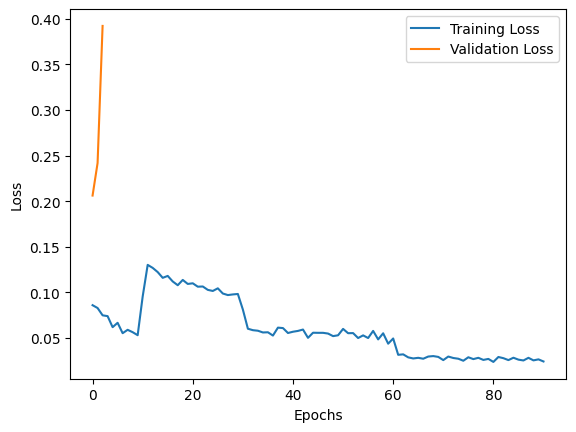

In [19]:
# Plot training and validation loss after training is complete
import matplotlib.pyplot as plt

# Extract loss values
training_loss = trainer.state.log_history
eval_loss = [entry['eval_loss'] for entry in training_loss if 'eval_loss' in entry]
train_loss = [entry['loss'] for entry in training_loss if 'loss' in entry]

# Plot the losses
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:")
print(results)


100%|██████████| 15270/15270 [07:43<00:00, 32.95it/s]

Evaluation Results:
{'eval_loss': 0.24178943037986755, 'eval_accuracy': 0.9390114118244184, 'eval_precision': 0.9162529600557753, 'eval_recall': 0.9937033126051078, 'eval_f1': 0.9534077974708877, 'eval_runtime': 463.7207, 'eval_samples_per_second': 263.421, 'eval_steps_per_second': 32.929, 'epoch': 3.0}


In [21]:
# Save the model and tokenizer
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
print("Model and tokenizer saved.")


Model and tokenizer saved.


In [27]:
import pandas as pd
from datasets import Dataset

# Load the devtest file
devtest_df = pd.read_json("en_devtest.jsonl", lines=True)

# Convert to Hugging Face Dataset format
devtest_dataset = Dataset.from_pandas(devtest_df)

print("Devtest dataset loaded successfully.")


Devtest dataset loaded successfully.


In [28]:

# Rename or select required columns
devtest_dataset = Dataset.from_pandas(devtest_df[['text', 'label']])

print(devtest_dataset.column_names)  # Should show ['text', 'label']


['text', 'label']


In [ ]:
results = trainer.evaluate(devtest_dataset)

print("Devtest Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")


[0, 1]


Map: 100%|██████████| 32557/32557 [00:00<00:00, 70384.14 examples/s]


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Load the tokenizer (ensure it's the same one used for training)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Replace with your model name if different

# Tokenize the devtest dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_devtest = devtest_dataset.map(tokenize_function, batched=True)

# Set the format for the dataset to work with PyTorch
tokenized_devtest.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Get predictions
predictions = trainer.predict(tokenized_devtest)

# Extract logits and convert to predicted labels
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)

# Extract true labels
true_labels = tokenized_devtest["label"]

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="binary")
recall = recall_score(true_labels, predicted_labels, average="binary")
f1 = f1_score(true_labels, predicted_labels, average="binary")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)



100%|██████████| 4070/4070 [02:25<00:00, 28.06it/s]

Accuracy: 0.7811223392818749
Precision: 0.7504776937775193
Recall: 0.9416762222453873
F1 Score: 0.8352750809061489
Confusion Matrix:
[[ 7364  6007]
 [ 1119 18067]]


In [36]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="binary")
recall = recall_score(true_labels, predicted_labels, average="binary")
f1 = f1_score(true_labels, predicted_labels, average="binary")
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"F1 Macro Score: {f1_macro}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7811223392818749
Precision: 0.7504776937775193
Recall: 0.9416762222453873
F1 Score: 0.8352750809061489
F1 Macro Score: 0.7546010253986222
Confusion Matrix:
[[ 7364  6007]
 [ 1119 18067]]


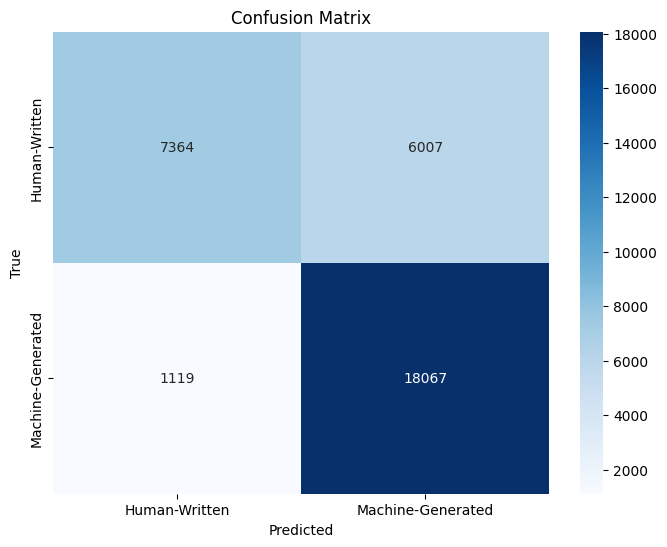

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human-Written', 'Machine-Generated'], yticklabels=['Human-Written', 'Machine-Generated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Testing Roberta model

In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import os

# Step 1: Load the Dataset
# Assuming the datasets are in your directory as JSONL files
roberta_train_data = load_dataset('json', data_files='en_train.jsonl')['train']
roberta_dev_data = load_dataset('json', data_files='en_dev.jsonl')['train']
roberta_test_data = load_dataset('json', data_files='en_devtest.jsonl')['train']

# Step 2: Initialize the RoBERTa Model and Tokenizer
roberta_model_name = "roberta-base"  # Use "roberta-large" for better performance
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=2)  # Binary classification

# Step 3: Preprocess the Dataset for RoBERTa
def preprocess_roberta_data(examples):
    encoded_inputs = roberta_tokenizer(
        examples["text"], max_length=512, truncation=True, padding="max_length"
    )
    encoded_inputs["labels"] = examples["label"]
    return encoded_inputs

roberta_train_data = roberta_train_data.map(preprocess_roberta_data, batched=True)
roberta_dev_data = roberta_dev_data.map(preprocess_roberta_data, batched=True)
roberta_test_data = roberta_test_data.map(preprocess_roberta_data, batched=True)

# Remove unnecessary columns
roberta_train_data = roberta_train_data.remove_columns(["text", "label"])
roberta_dev_data = roberta_dev_data.remove_columns(["text", "label"])
roberta_test_data = roberta_test_data.remove_columns(["text", "label"])

# Set dataset format
roberta_train_data.set_format("torch")
roberta_dev_data.set_format("torch")
roberta_test_data.set_format("torch")

# Step 4: Define Training Arguments
roberta_training_args = TrainingArguments(
    output_dir="./fine_tuned_model_roberta/roberta_results",  # Directory to save RoBERTa results
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./results_roberta/roberta_logs",  # Logging directory for RoBERTa
    logging_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Use loss as the metric for best model
    greater_is_better=False,
    seed=42,
)

# Step 5: Initialize the Trainer
roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=roberta_train_data,
    eval_dataset=roberta_dev_data,
    tokenizer=roberta_tokenizer,
)

# Step 6: Fine-Tune the Model
roberta_trainer.train()

# Step 7: Save the Model and Tokenizer Separately
roberta_save_dir = "./fine_tuned_model/roberta_model"
os.makedirs(roberta_save_dir, exist_ok=True)
roberta_model.save_pretrained(roberta_save_dir)
roberta_tokenizer.save_pretrained(roberta_save_dir)

print(f"RoBERTa model and tokenizer saved to {roberta_save_dir}")


c:\Users\Ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Ragha\AppData\Local\Temp\ipykernel_28372\166532991.py:58: FutureWarning: `tokenizer` is depr

{'loss': 0.3314, 'grad_norm': 23.1492919921875, 'learning_rate': 1.9476110645431688e-05, 'epoch': 0.03}


  5%|▌         | 500/9544 [05:05<1:31:03,  1.66it/s]

{'loss': 0.199, 'grad_norm': 14.589445114135742, 'learning_rate': 1.895222129086337e-05, 'epoch': 0.05}


  8%|▊         | 750/9544 [07:36<1:28:25,  1.66it/s]

{'loss': 0.1648, 'grad_norm': 27.968393325805664, 'learning_rate': 1.8428331936295057e-05, 'epoch': 0.08}


 10%|█         | 1000/9544 [10:07<1:26:05,  1.65it/s]

{'loss': 0.1479, 'grad_norm': 17.69414710998535, 'learning_rate': 1.790444258172674e-05, 'epoch': 0.1}


 13%|█▎        | 1250/9544 [12:38<1:23:27,  1.66it/s]

{'loss': 0.1401, 'grad_norm': 5.533641815185547, 'learning_rate': 1.7380553227158426e-05, 'epoch': 0.13}


 16%|█▌        | 1500/9544 [15:09<1:20:59,  1.66it/s]

{'loss': 0.1285, 'grad_norm': 4.973155498504639, 'learning_rate': 1.6856663872590113e-05, 'epoch': 0.16}


 18%|█▊        | 1750/9544 [17:40<1:18:23,  1.66it/s]

{'loss': 0.1175, 'grad_norm': 6.234440326690674, 'learning_rate': 1.6332774518021796e-05, 'epoch': 0.18}


 21%|██        | 2000/9544 [20:11<1:16:01,  1.65it/s]

{'loss': 0.1129, 'grad_norm': 5.831968307495117, 'learning_rate': 1.580888516345348e-05, 'epoch': 0.21}


 24%|██▎       | 2250/9544 [22:42<1:13:25,  1.66it/s]

{'loss': 0.1111, 'grad_norm': 9.8239164352417, 'learning_rate': 1.5284995808885165e-05, 'epoch': 0.24}


 26%|██▌       | 2500/9544 [25:13<1:10:53,  1.66it/s]

{'loss': 0.1141, 'grad_norm': 12.073816299438477, 'learning_rate': 1.476110645431685e-05, 'epoch': 0.26}


 29%|██▉       | 2750/9544 [27:44<1:08:25,  1.65it/s]

{'loss': 0.1043, 'grad_norm': 2.8581156730651855, 'learning_rate': 1.4237217099748534e-05, 'epoch': 0.29}


 31%|███▏      | 3000/9544 [30:15<1:05:58,  1.65it/s]

{'loss': 0.0981, 'grad_norm': 2.6302435398101807, 'learning_rate': 1.3713327745180219e-05, 'epoch': 0.31}


 34%|███▍      | 3250/9544 [32:46<1:03:12,  1.66it/s]

{'loss': 0.0931, 'grad_norm': 2.9520187377929688, 'learning_rate': 1.3189438390611903e-05, 'epoch': 0.34}


 37%|███▋      | 3500/9544 [35:17<1:00:45,  1.66it/s]

{'loss': 0.1016, 'grad_norm': 9.174103736877441, 'learning_rate': 1.266554903604359e-05, 'epoch': 0.37}


 39%|███▉      | 3750/9544 [37:47<58:18,  1.66it/s]  

{'loss': 0.0939, 'grad_norm': 27.9623966217041, 'learning_rate': 1.2141659681475273e-05, 'epoch': 0.39}


 42%|████▏     | 4000/9544 [40:18<55:51,  1.65it/s]

{'loss': 0.0884, 'grad_norm': 6.636600971221924, 'learning_rate': 1.1617770326906959e-05, 'epoch': 0.42}


 45%|████▍     | 4250/9544 [42:49<53:02,  1.66it/s]

{'loss': 0.0909, 'grad_norm': 11.09776496887207, 'learning_rate': 1.1093880972338642e-05, 'epoch': 0.45}


 47%|████▋     | 4500/9544 [45:20<50:49,  1.65it/s]

{'loss': 0.088, 'grad_norm': 6.608687400817871, 'learning_rate': 1.0569991617770328e-05, 'epoch': 0.47}


 50%|████▉     | 4750/9544 [47:51<48:25,  1.65it/s]

{'loss': 0.0832, 'grad_norm': 9.565352439880371, 'learning_rate': 1.0046102263202013e-05, 'epoch': 0.5}


 52%|█████▏    | 5000/9544 [50:22<45:50,  1.65it/s]

{'loss': 0.0767, 'grad_norm': 8.660136222839355, 'learning_rate': 9.522212908633697e-06, 'epoch': 0.52}


 55%|█████▌    | 5250/9544 [52:53<43:18,  1.65it/s]

{'loss': 0.0792, 'grad_norm': 6.071634769439697, 'learning_rate': 8.998323554065382e-06, 'epoch': 0.55}


 58%|█████▊    | 5500/9544 [55:24<40:39,  1.66it/s]

{'loss': 0.0836, 'grad_norm': 2.9892780780792236, 'learning_rate': 8.474434199497067e-06, 'epoch': 0.58}


 60%|██████    | 5750/9544 [57:55<38:07,  1.66it/s]

{'loss': 0.0748, 'grad_norm': 6.143428325653076, 'learning_rate': 7.950544844928751e-06, 'epoch': 0.6}


 63%|██████▎   | 6000/9544 [1:00:25<35:28,  1.66it/s]

{'loss': 0.0765, 'grad_norm': 10.804542541503906, 'learning_rate': 7.426655490360436e-06, 'epoch': 0.63}


 65%|██████▌   | 6250/9544 [1:02:55<32:56,  1.67it/s]

{'loss': 0.0765, 'grad_norm': 10.121590614318848, 'learning_rate': 6.902766135792121e-06, 'epoch': 0.65}


 68%|██████▊   | 6500/9544 [1:05:26<30:28,  1.66it/s]

{'loss': 0.0708, 'grad_norm': 9.39018440246582, 'learning_rate': 6.378876781223806e-06, 'epoch': 0.68}


 71%|███████   | 6750/9544 [1:07:56<27:53,  1.67it/s]

{'loss': 0.0723, 'grad_norm': 6.227938175201416, 'learning_rate': 5.854987426655491e-06, 'epoch': 0.71}


 73%|███████▎  | 7000/9544 [1:10:26<25:27,  1.67it/s]

{'loss': 0.075, 'grad_norm': 5.966060161590576, 'learning_rate': 5.331098072087175e-06, 'epoch': 0.73}


 76%|███████▌  | 7250/9544 [1:12:57<22:59,  1.66it/s]

{'loss': 0.0698, 'grad_norm': 8.725191116333008, 'learning_rate': 4.807208717518861e-06, 'epoch': 0.76}


 79%|███████▊  | 7500/9544 [1:15:27<20:24,  1.67it/s]

{'loss': 0.066, 'grad_norm': 5.627066612243652, 'learning_rate': 4.283319362950545e-06, 'epoch': 0.79}


 81%|████████  | 7750/9544 [1:17:57<17:56,  1.67it/s]

{'loss': 0.0663, 'grad_norm': 2.793145179748535, 'learning_rate': 3.75943000838223e-06, 'epoch': 0.81}


 84%|████████▍ | 8000/9544 [1:20:28<15:25,  1.67it/s]

{'loss': 0.0677, 'grad_norm': 9.108323097229004, 'learning_rate': 3.235540653813915e-06, 'epoch': 0.84}


 86%|████████▋ | 8250/9544 [1:22:58<12:53,  1.67it/s]

{'loss': 0.0678, 'grad_norm': 11.334199905395508, 'learning_rate': 2.7116512992455996e-06, 'epoch': 0.86}


 89%|████████▉ | 8500/9544 [1:25:28<10:27,  1.66it/s]

{'loss': 0.0676, 'grad_norm': 6.095330238342285, 'learning_rate': 2.1877619446772842e-06, 'epoch': 0.89}


 92%|█████████▏| 8750/9544 [1:27:58<07:56,  1.67it/s]

{'loss': 0.0664, 'grad_norm': 4.571455955505371, 'learning_rate': 1.6638725901089693e-06, 'epoch': 0.92}


 94%|█████████▍| 9000/9544 [1:30:29<05:26,  1.67it/s]

{'loss': 0.0592, 'grad_norm': 5.508184909820557, 'learning_rate': 1.1399832355406539e-06, 'epoch': 0.94}


 97%|█████████▋| 9250/9544 [1:32:59<02:55,  1.67it/s]

{'loss': 0.0624, 'grad_norm': 3.800098419189453, 'learning_rate': 6.160938809723386e-07, 'epoch': 0.97}


100%|█████████▉| 9500/9544 [1:35:29<00:26,  1.67it/s]

{'loss': 0.0678, 'grad_norm': 11.24952507019043, 'learning_rate': 9.220452640402346e-08, 'epoch': 1.0}


                                                     
100%|██████████| 9544/9544 [1:50:42<00:00,  2.13it/s]

{'eval_loss': 0.1662149578332901, 'eval_runtime': 884.1588, 'eval_samples_per_second': 296.053, 'eval_steps_per_second': 37.007, 'epoch': 1.0}


100%|██████████| 9544/9544 [1:50:45<00:00,  1.44it/s]


{'train_runtime': 6645.093, 'train_samples_per_second': 91.912, 'train_steps_per_second': 1.436, 'train_loss': 0.09869814006500852, 'epoch': 1.0}
RoBERTa model and tokenizer saved to ./fine_tuned_model/roberta_model


100%|██████████| 4070/4070 [01:56<00:00, 35.07it/s]


                   precision    recall  f1-score   support

    Human-Written       0.91      0.58      0.71     13371
Machine-Generated       0.77      0.96      0.85     19186

         accuracy                           0.81     32557
        macro avg       0.84      0.77      0.78     32557
     weighted avg       0.83      0.81      0.79     32557



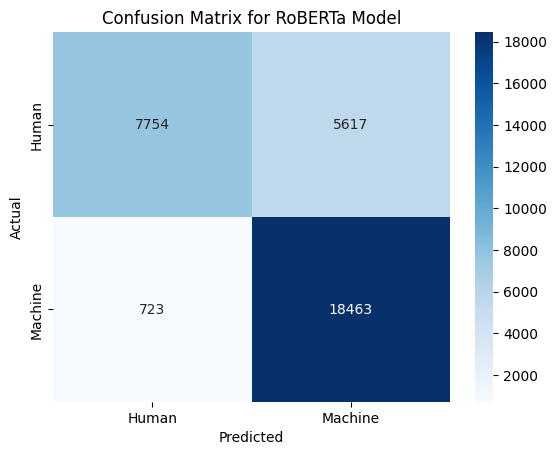

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
roberta_predictions = roberta_trainer.predict(roberta_test_data)
predicted_labels = np.argmax(roberta_predictions.predictions, axis=1)
true_labels = roberta_test_data['labels']

# Compute metrics
print(classification_report(true_labels, predicted_labels, target_names=["Human-Written", "Machine-Generated"]))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "Machine"], yticklabels=["Human", "Machine"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for RoBERTa Model")
plt.show()


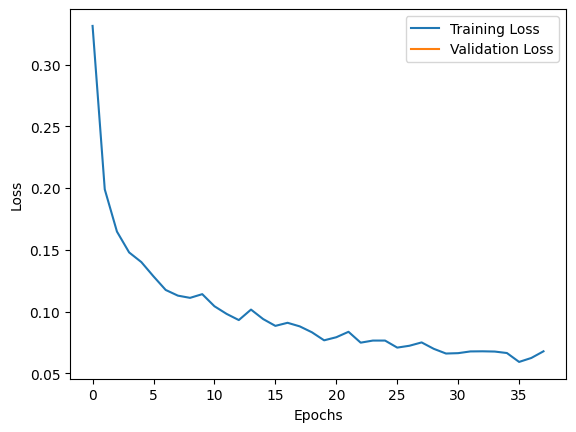

In [3]:
# Plot training and validation loss after training is complete
import matplotlib.pyplot as plt

# Extract loss values
training_loss_roberta = roberta_trainer.state.log_history
eval_loss = [entry['eval_loss'] for entry in training_loss_roberta if 'eval_loss' in entry]
train_loss = [entry['loss'] for entry in training_loss_roberta if 'loss' in entry]

# Plot the losses
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [4]:
print(roberta_trainer.state.log_history)


[{'loss': 0.3314, 'grad_norm': 23.1492919921875, 'learning_rate': 1.9476110645431688e-05, 'epoch': 0.026194467728415757, 'step': 250}, {'loss': 0.199, 'grad_norm': 14.589445114135742, 'learning_rate': 1.895222129086337e-05, 'epoch': 0.052388935456831515, 'step': 500}, {'loss': 0.1648, 'grad_norm': 27.968393325805664, 'learning_rate': 1.8428331936295057e-05, 'epoch': 0.07858340318524727, 'step': 750}, {'loss': 0.1479, 'grad_norm': 17.69414710998535, 'learning_rate': 1.790444258172674e-05, 'epoch': 0.10477787091366303, 'step': 1000}, {'loss': 0.1401, 'grad_norm': 5.533641815185547, 'learning_rate': 1.7380553227158426e-05, 'epoch': 0.1309723386420788, 'step': 1250}, {'loss': 0.1285, 'grad_norm': 4.973155498504639, 'learning_rate': 1.6856663872590113e-05, 'epoch': 0.15716680637049454, 'step': 1500}, {'loss': 0.1175, 'grad_norm': 6.234440326690674, 'learning_rate': 1.6332774518021796e-05, 'epoch': 0.18336127409891032, 'step': 1750}, {'loss': 0.1129, 'grad_norm': 5.831968307495117, 'learning